# Data Preprocessing
---

The main objective is to extract strings containing names and everything else, for this DBpedia is used as the main source of the data

The **Transitive-Type** file helps to identify if a resource is a Person or not.

[instance_types_transitive_en.ttl.bz2](http://downloads.dbpedia.org/2016-10/core-i18n/en/instance_types_transitive_en.ttl.bz2) **125MB** (Compressed)

**Mapping Based Literals** contains all the strings related to the resources included inside the Transitive-Type file, not only names but all kinds of strings.

[mappingbased_literals_en.ttl.bz2](http://downloads.dbpedia.org/2016-10/core-i18n/en/mappingbased_literals_en.ttl.bz2) **131MB** (Compressed)

In [1]:
import pandas as pd
import bz2 # Read the files without extracting them
import re
import numpy as np
import itertools # Produce string combinations easily

# Transitive-Type File
transitive_type_file = 'data/instance_types_transitive_en.ttl.bz2'
# Mappings-Based File
mappings_based_file = 'data/mappingbased_literals_en.ttl.bz2'

#### Transitive-Type Triples
```
<http://dbpedia.org/resource/Abraham_Lincoln> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://schema.org/Person> .
<http://dbpedia.org/resource/Alabama> <http://www.w3.org/1999/02/22-rdf-syntax-ns#type> <http://dbpedia.org/ontology/Place> .
```

This file has the format of **subject - predicate - object** where the subject is the resource like *Abraham Lincoln* and the type of entity is like *Person*

Because every subject is linked to several objects, we can use a counter approach, where if the subject has at least one Person related ontology, we mark this resource as a person.

In [2]:
# Build Resource Dictionaries
dictionary = {}

is_person_re = re.compile(r'<http://.+/Person>$') # Regex to detect if the resource has the ontology Person
get_resource_re = re.compile(r'<http://dbpedia.org/resource/(.+)>') # Regex to extract the resource name

with bz2.open(transitive_type_file, 'r') as f:
    while True:
        # Becase a compressed file is being readed, each lines needs to be decoded into UTF-8
        line = f.readline().decode('utf-8')
        if not line:
            break
        if not line.startswith("#"): # Avoiding commented lines
            triple = line.split(" ") # Split the string into a triple
            resource = get_resource_re.search(triple[0]).group(1) # Get the resource name
            if resource not in dictionary: # Check if that resource was already passed through
                dictionary[resource] = 0
            # If the resource has the ontology Person, increase resource counter
            dictionary[resource] += 1 if is_person_re.match(triple[2]) else 0

#### Mapping Based Literals
```
http://dbpedia.org/resource/Academy_Award_for_Best_Production_Design> <http://xmlns.com/foaf/0.1/name> "Academy Award for Best Production Design"@en .
<http://dbpedia.org/resource/Academy_Award_for_Best_Production_Design> <http://dbpedia.org/ontology/year> "1929"^^<http://www.w3.org/2001/XMLSchema#gYear> .
<http://dbpedia.org/resource/Ayn_Rand> <http://xmlns.com/foaf/0.1/name> "Ayn Rand"@en .
<http://dbpedia.org/resource/Ayn_Rand> <http://dbpedia.org/ontology/pseudonym> "Ayn Rand"@en .
<http://dbpedia.org/resource/Ayn_Rand> <http://dbpedia.org/ontology/birthName> "Alisa Zinov'yevna Rosenbaum"@en .
<http://dbpedia.org/resource/Ayn_Rand> <http://dbpedia.org/ontology/birthDate> "1905-02-02"^^<http://www.w3.org/2001/XMLSchema#date> .
```

The format for this file is **subject - attribute - string**

If the subject is in the dictionary we created and the counter is bigger than 0, then we can label those strings as names and because we also need strings that are not names, we save all the possible strings with their respective label.

In [3]:
attributes = ['name', 'birthName', 'alias', 'pseudonym'] # Attributes that contain Person name

strings = []
labels = []

# Regex to extract the attribute (e.g. birthName, birthDate, etc.)
attribute_regex = re.compile(r'^<http://.+/(.+)>$')
# Regex to extract the actual string
string_regex = re.compile(r' "(.+)"')
# Some few strings contain extra information inside parenthesis, so we avoid them
parenthesis_regex = re.compile(r'\(.+\)')

with bz2.open(mappings_based_file, 'r') as f:
    while True:
        line = f.readline().decode('utf-8')
        if not line:
            break
        if not line.startswith("#"):
            triple = line.split(" ")
            resource = get_resource_re.search(triple[0]).group(1)
            attribute = attribute_regex.search(triple[1]).group(1)
            if resource in dictionary:
                string = string_regex.search(line).group(1)
                # If doesn't have parenthesis we append them to the arrays
                if not parenthesis_regex.search(string):
                    strings.append(string)
                    # If the counter for that resource in the dictionary is more than 0 we set True otherwise False.
                    labels.append(True if dictionary[resource] and attribute in attributes else False)    

We load the data into a *Pandas Dataframe* for easier manipulation, and we remove duplicates.

In [4]:
df = pd.DataFrame({'string': strings, 'is_person_name': labels})
dedup_df = df.drop_duplicates(subset='string')
dedup_df.sample(n=10)

,is_person_name,string
9247870,False,Bhavihal
2612329,False,1.5327E8
1018988,True,Henri van den Broek
2428934,True,Alvin Hansen
45636,False,1915-04-21
3365742,False,Tropical North Learning Academy- Smithfield St...
11446295,True,Simon Hanna
7001578,False,179805747
8595912,True,Taylor Marie Roberts
2615365,False,By Time Alone


In [5]:
import locale
locale.setlocale(locale.LC_ALL, 'en_GB')

# Function just to print the fancy commas
def formatNumber(n):
    return locale.format("%d", n, grouping=True)

The dataset built from DBpedia generated around *4 million* samples, but only *1 million* are names. We can balance the classes, undersampling the ones that are not names, but decided to generate *2 million* more of names to have *6 million* of strings in total.

In [6]:
print("Total: {}".format(formatNumber(dedup_df.shape[0])))
print("Names: {}".format(formatNumber(dedup_df[dedup_df['is_person_name']==True].shape[0])))

Total: 4,177,368
Names: 1,071,272


In [7]:
%matplotlib inline
import seaborn as sns # Seaborn to plot distributions
import matplotlib.pyplot as plt # Needed for Seaborn

We plot the distribution with the lengths of the strings, we do have some strings with almost **1,400** characters but most of them are less than **50** characters.

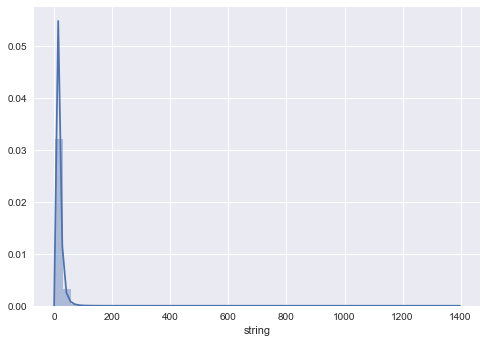

In [8]:
sns.distplot(dedup_df['string'].apply(lambda s: len(s)))

We remove all the samples that are bigger than **50**, the dataset only loses a few thousand samples.

In [9]:
reduced_df = dedup_df[dedup_df['string'].apply(lambda s: len(s))<=50]

print("Total: {}".format(formatNumber(reduced_df.shape[0])))
print("Names: {}".format(formatNumber(reduced_df[reduced_df['is_person_name']==True].shape[0])))

Total: 4,099,926
Names: 1,069,256


If we plot the length distribution we can see it covers most of the samples.

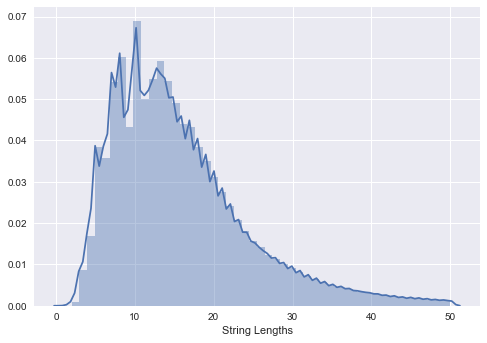

In [10]:
sns.distplot(reduced_df['string'].apply(lambda s: len(s)), axlabel='String Lengths')

Function to detect if the string has latin characters the **p** variable is for the percentage of accepted non-latin characters.

This is useful when some strings contain special letters (ç, ñ, ß, etc.)

In [11]:
def hasLatinChar(s, p=0.0):
    count = 0
    for c in s:
        if ord(c) > 255:
            count += 1
    return True if len(s) * p > count else False

There are strings that have non-latin characters (Arabic, Russian, Chinese, etc.) So we remove them as well.

In [12]:
reduced_df[reduced_df['string'].apply(lambda s: hasLatinChar(s, 0.3))==False].sample(n=10)

,is_person_name,string
9962357,False,勤以为学 信以立身
11152504,False,واشقان
2278634,False,Καπανδρίτι
12095930,False,موتورحاجي پيرمحمد
9625195,False,Ru-вздрогнуть.ogg
11490044,False,السبع بيار
10565151,False,نوجان
12859927,False,कावलि
10889229,False,بن باباجان
11061534,False,دهستان ليراوئ جنوبي


After removing them we end with *3.9 Million* samples and with *1 million* of names, we are still *2 million* behind to balance the classes.

In [13]:
clean_df = reduced_df[reduced_df['string'].apply(lambda s: hasLatinChar(s, 0.3))==True]
print("Total: {}".format(formatNumber(clean_df.shape[0])))
print("Names: {}".format(formatNumber(clean_df[clean_df['is_person_name']==True].shape[0])))

Total: 3,974,333
Names: 1,056,677


To generate more names, I downloaded CSV files for First Names and Last Names

[First Names CSV](http://www.quietaffiliate.com/Files/CSV_Database_of_First_Names.csv)

[Last Names CSV](http://www.quietaffiliate.com/Files/CSV_Database_of_Last_Names.csv)

In [14]:
first_names = pd.read_csv('data/First_Names.csv', index_col=False)
print("First Names: {}".format(formatNumber(first_names.shape[0])))

First Names: 5,494


In [15]:
last_names = pd.read_csv('data/Last_Names.csv', index_col=False)
print("Last Names: {}".format(formatNumber(last_names.shape[0]))) 

Last Names: 88,799


We sample *1,000* first names and *2,000* last names to do a product operation and generate 2 million random names.

In [16]:
# Create 2 million names
n_last_names = 2000
n_first_names = 1000

generated_names = np.array(list(map(lambda s: "{} {}".format(s[0], s[1]),
                                    itertools.product(first_names['firstname'].sample(n=n_first_names).values,
                                                      last_names['lastname'].sample(n=n_last_names).values))
                               )
                          )
generanted = pd.DataFrame({'string':generated_names})
generanted['is_person_name'] = pd.Series(True, index=generanted.index)

In [17]:
generanted.sample(n=10)

,string,is_person_name
1311635,Shavon Sikander,True
1437702,Donetta Lehrfeld,True
610179,Daine Delee,True
233763,Krystina Obergfell,True
1029114,Celina Holmen,True
217059,Normand Germon,True
1801856,Raleigh Politano,True
1335778,Gigi Lanoie,True
276677,Joy Sottosanti,True
760801,Adria Turocy,True


In [18]:
first_names.columns = ['string']
first_names['is_person_name'] = pd.Series(True, index=first_names.index)

In [19]:
first_names.sample(n=10)

,string,is_person_name
2843,Kizzy,True
4144,Peter,True
2825,Kimiko,True
1913,Gerda,True
602,Britt,True
4222,Randal,True
5485,Zoila,True
3047,Leanora,True
4333,Riley,True
5183,Tyler,True


In [20]:
last_names.columns = ['string']
last_names['is_person_name'] = pd.Series(True, index=last_names.index)

In [21]:
last_names.sample(n=10)

,string,is_person_name
45652,Leigh,True
24183,Expose,True
51333,Mcclodden,True
37360,Ibanez,True
10048,Broomhead,True
69659,Sawallich,True
78460,Tanna,True
34282,Hellard,True
37559,Inbody,True
15158,Colaluca,True


We concatenate all the strings extracted from dbpedia, first names, last names and generated combinations of names, this totals *6 million* samples with roughly *3 million* being names.

In [22]:
full_dataset = pd.concat([clean_df, generanted, first_names, last_names]).drop_duplicates(subset='string')

print("Name:{}".format(formatNumber(full_dataset[full_dataset['is_person_name']==True].shape[0])))
print("Total:{}".format(formatNumber(full_dataset.shape[0])))

Name:3,107,879
Total:6,025,535


In [23]:
full_dataset.to_csv('data/full_names.csv', index=False)